In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
plt.ion()


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


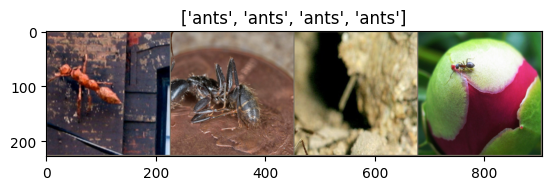

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4779 Acc: 0.7623
val Loss: 0.2953 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5441 Acc: 0.7705
val Loss: 0.6546 Acc: 0.7451

Epoch 2/24
----------
train Loss: 0.4429 Acc: 0.8238
val Loss: 0.2261 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5378 Acc: 0.7746
val Loss: 0.2136 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3897 Acc: 0.8320
val Loss: 0.2606 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5260 Acc: 0.7992
val Loss: 0.2243 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3916 Acc: 0.8402
val Loss: 0.2172 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4114 Acc: 0.8115
val Loss: 0.1792 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2308 Acc: 0.9180
val Loss: 0.1773 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2782 Acc: 0.8730
val Loss: 0.1682 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3769 Acc: 0.8525
val Loss: 0.1502 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3095 Acc: 0.8566
val Loss: 0.2002 Acc: 0.9346

Ep

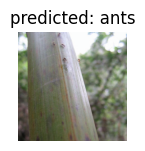

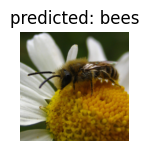

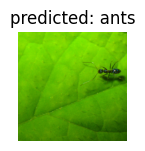

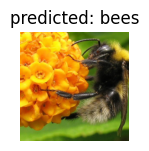

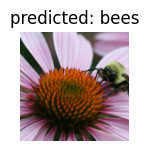

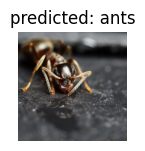

In [11]:
visualize_model(model_ft)

In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6996 Acc: 0.6516
val Loss: 0.2014 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4233 Acc: 0.8033
val Loss: 0.2656 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4603 Acc: 0.7869
val Loss: 0.1847 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3096 Acc: 0.8566
val Loss: 0.1747 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4427 Acc: 0.8156
val Loss: 0.1630 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5505 Acc: 0.7828
val Loss: 0.1643 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3004 Acc: 0.8607
val Loss: 0.1744 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4083 Acc: 0.8361
val Loss: 0.1892 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4483 Acc: 0.7910
val Loss: 0.1984 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3335 Acc: 0.8279
val Loss: 0.1942 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2413 Acc: 0.8934
val Loss: 0.2001 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3107 Acc: 0.8689
val Loss: 0.1801 Acc: 0.9412

Ep

In [14]:
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for p in model.parameters(): p.requires_grad = False
for p in model.layer4.parameters(): p.requires_grad = True
num_f = model.fc.in_features
model.fc = nn.Linear(num_f, 2)  # trainable by default

# discriminative LRs: bigger for head, smaller for last block
params = [
    {"params": model.layer4.parameters(), "lr": 3e-4},
    {"params": model.fc.parameters(),     "lr": 1e-3},
]
optimizer = torch.optim.SGD(params, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3955 Acc: 0.8402
val Loss: 0.1872 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.3121 Acc: 0.8811
val Loss: 0.1869 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3403 Acc: 0.8566
val Loss: 0.1758 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3369 Acc: 0.8443
val Loss: 0.1896 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4333 Acc: 0.8279
val Loss: 0.1912 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3257 Acc: 0.8689
val Loss: 0.1958 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4711 Acc: 0.8115
val Loss: 0.2022 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4535 Acc: 0.7992
val Loss: 0.1924 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3975 Acc: 0.8402
val Loss: 0.1735 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3625 Acc: 0.8402
val Loss: 0.1825 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3959 Acc: 0.8525
val Loss: 0.1796 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3668 Acc: 0.8402
val Loss: 0.1833 Acc: 0.9477

Ep